# Reading data from the Acre Road Radio Telescope

The data from the H1 radio telescope is stored in binary form, as spectra which are concatenated within the file.

To read these we'll need a bit of logic which will reshape the data into something we can perform analysis on.

The exact structure of these files will depend on the length of each spectrum, which is decided when the observations are set up. 
In previous years we've used a configuration which produced spectra which are 256 bins long.

Binary data can be read using the `numpy.fromfile` function.

(We can run `import numpy as np` so that we can use `np` as a shorthand for "`numpy`" in our code.)

In [58]:
import numpy as np

All of the archival data for the telescope is available in the observatory's data archives.

You can find these in the `/data/observatory` directory; the data from previous SRT observing campaigns is in the `srt` directory within this.

In [ ]:
!ls /data/observatory/srt

(That cell, by the way, doesn't contain python, but contains a terminal command; you can run single-line terminal commands in JupyterLab by starting a cell with a bang [!]).

Let's load an example from the 2018 observing campaign. We can see a list of all the available data files from this year by running this command.

In [ ]:
!ls -l /data/observatory/srt/archive/srt2018/ra*.dat

The name of each file has a predictable format (the software which runs the observations should always save the files this way).

These follow the pattern `ra<right ascension at start>dec<declination at start>time<start time>.dat`. 

The format of the start time is in `ISO 8601` format, in the local timezone (which should be UTC+0:00 for all of the observations, but if you notice anything odd with any of the files from some years made in March or April then this might be something that needs to be corrected).

It's a good idea to avoid hard-coding things like filenames into our code, so for this example I'll define a variable to contain the filename.

In [46]:
datafile = "/data/observatory/srt/archive/srt2018/ra0.00dec-4.00time2018-03-18T13:50:00.000.dat"

The filename for each observation contains metadata which we can use to determine the sky location of each observation.

Using regular expressions we can parse this data, so that we can use it later.

The next cell defines a function which does this for us; for now you don't need to worry too much about what this is doing though.

In [47]:
import re
from astropy.time import Time
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u

def extract_metadata(filename):
    """
    Extract all of the meta data contained within the name of a data file.
    
    Parameters
    ----------
    filename : str
        The name of the file, can optionally include the full path, 
        in which case the name is taken to be everything after the final
        slash.
        
    Returns
    -------
    position : `astropy.skycoord`
        The sky position at which the file starts
    time : `astropy.Time`
        The time at which the file starts.
    """
    
    a = re.compile("ra(.*)dec(.*)time(.*).dat")
    filepath = filename.split('/')

    s_ra = float(a.search(filepath[-1]).group(1))
    s_dec = float(a.search(filepath[-1]).group(2))
    s_time = a.search(filepath[-1]).group(3)
    
    
    time = Time(s_time, format='isot', scale='utc')
    position = SkyCoord(s_ra*u.deg, s_dec*u.deg, frame=ICRS, obstime = time)
    return position, time

We should now be ready to read the data from the stored data files.

The data is stored as 32-bit floating point data. The `numpy.fromfile` function is able to do most of the work of loading this for us, but we need to help it by telling it that the numbers in the file are 32-bit floats.
Fortunately `numpy` has a built-in constant called `numpy.float32` which we can give to the `numpy` function, and it does the heavy lifting for us.

In [57]:
data = np.fromfile(datafile, dtype=np.float32)

We now have one enormous array of data (you can check its shape by printing the value of `data.shape`).
This isn't quite what we want. The spectra in the file are all concatenated, but we want to be able to pull each of them out individually.

There are a couple of ways that we could do this, for example, you could write a for loop to iterate over blocks of 256 data in the array. However, `numpy` allows us to do something a bit faster. We can "reshape" our 1D array into a 2D array which has each spectrum lying along a row, so that each column always represents the same frequency bin.

![](./figures/data-format.svg)

We know that there should be 256 frequency bins, so let's put that in a variable.

In [49]:
spec_len = 256

The `np.reshape` command then lets us reshape the array into an $n\times 256$ array. By passing $-1$ as the length of the "spectrum number" axis, numpy will determine the correct length to make this for us. (It's just calculating `len(data) / spec_len`).

In [64]:
data = np.reshape(data, [-1,spec_len])

We can now extract the metadata from the file name, which we'll need in the next step.

In [65]:
position, time = extract_metadata(datafile)

The `position` variable contains the coordinates of the start point for the observation using a special data object from `astropy`.

In [66]:
position

<SkyCoord (ICRS): (ra, dec) in deg
    (0., -4.)>

The time variable also contains the time in a computable format.

In [67]:
time

<Time object: scale='utc' format='isot' value=2018-03-18T13:50:00.000>

Most of the data we have access to from previous years are "drift scans".

A drift scan is an easy way of making observations along an entire circle in the sky as it moves over the telescope; we simply point the telescope at a given azimuth and altitude, and leave it to measure and record spectra for 24 hours*. The earth's rotation then leaves us with observations along a circle.

While this approach is simple, it's inefficient, but let's stick with it for the moment.

Because we start each observation at a different right ascension it can be difficult to compare different sets of observations.

Fortunately, the way that we've loaded our data makes it simple to rearrange things so that the first spectrum in each data set is recorded at the same right ascension.

We can use the `numpy.roll` function for this, and use this roll to align things.

In [68]:
roll = int((position.ra/360).value * len(data)/spec_len)
data = np.roll(data, roll, axis=0)

Let's have a quick look at the data using matplotlib.

In [69]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Spectrum number')

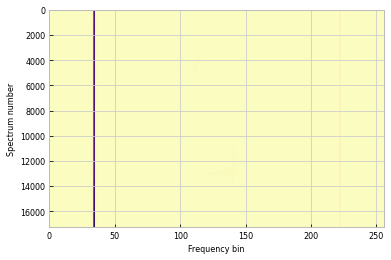

In [70]:
f, ax = plt.subplots(1,1)
ax.imshow(data, aspect="auto")
ax.set_xlabel("Frequency bin")
ax.set_ylabel("Spectrum number")

There's not a lot to see right now; we'll get back to why this is in more detail soon.

For now we can just take a slice through the middle of the spectrum which is where the astrophysical data is anyway.

Text(0, 0.5, 'Spectrum number')

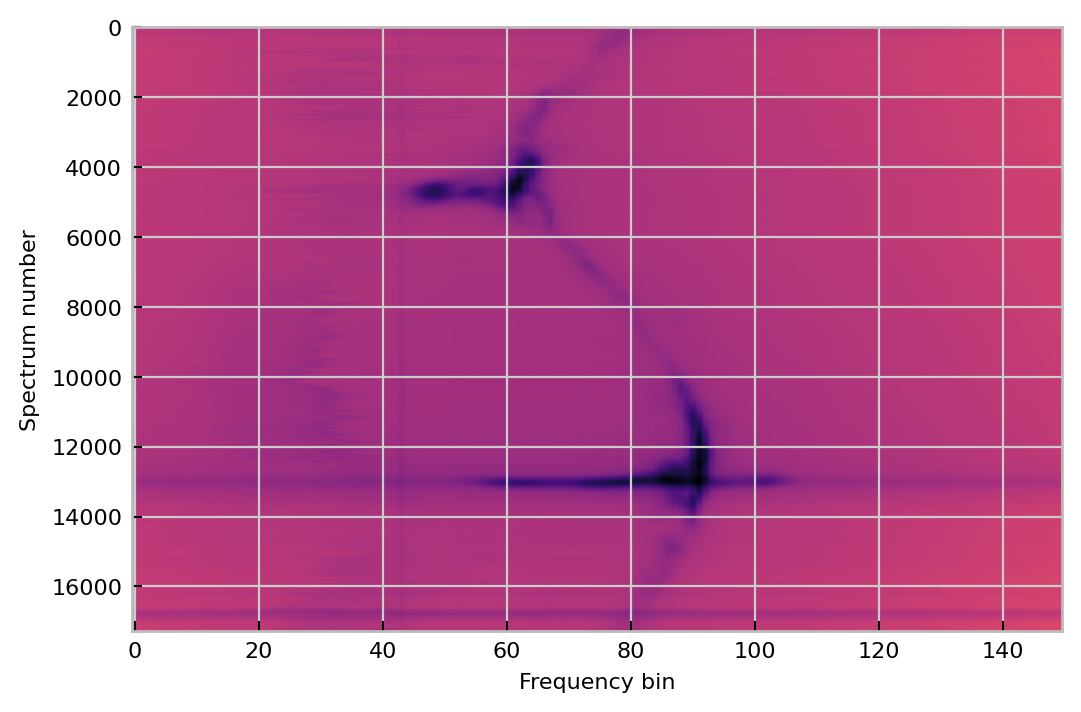

In [74]:
f, ax = plt.subplots(1,1, dpi=200)
ax.imshow(data[:, 50:200], aspect="auto")
ax.set_xlabel("Frequency bin")
ax.set_ylabel("Spectrum number")

You can now see that there are some features. 
The most prominent of these is the dark track which snakes around the centre of the spectrum. This is the HI line!

Something to think about: Why does it have this shape?

We can also see some evidence of intereference in the observations (the lighter smeared-out signal between bins 20 and 40 in the new plot).

This brings to an end this little tutorial on reading data files from the SRT, but this is only the beginning of the process of analysing the data.